In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

2023-11-11 14:53:50.359547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 14:53:50.359599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 14:53:50.359620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 14:53:50.365024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-11 14:53:51.886275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:51.889960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:51.889993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


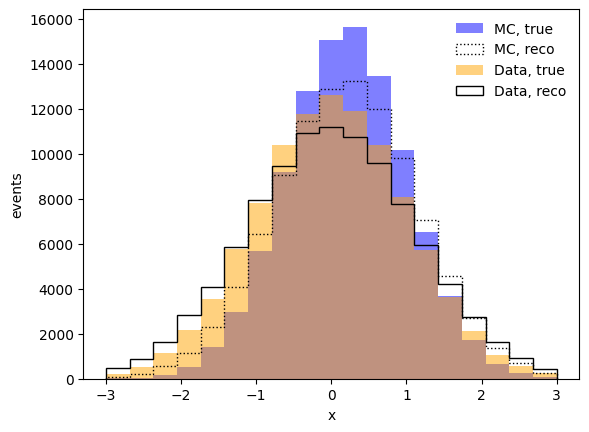

In [3]:
N = 10**5

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)


In [4]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-11-11 14:53:52.279827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:52.279902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:52.279921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:52.496577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 14:53:52.496619: I tensorflow/compile

In [5]:
myweights = of.omnifold(theta0,theta_unknown_S,2,model)

2023-11-11 14:53:53.526907: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-11 14:53:55.097194: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f80697671b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-11 14:53:55.097236: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-11-11 14:53:55.106724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-11 14:53:55.126851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-11 14:53:55.196088: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 0s 1ms/step


In [10]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G, weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)





Error in callback <function _draw_all_if_interactive at 0x7f8241d33640> (for post_execute), with arguments args (),kwargs {}:


TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 640x480 with 1 Axes>